In [28]:
import matplotlib
import numpy as np
import psutil
import ray
import os
import seaborn as sns
import time

import matplotlib.pyplot as plt
import numpy.linalg as la

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [29]:
@ray.remote
class ParameterServer(object):
    def __init__(self, lr, asynchronous):
        self.x = np.zeros(dim)
        self.lr = lr
        self.asynchronous = asynchronous

    def apply_gradients(self, grad, *gradients):
        if self.asynchronous:
            self.x -= self.lr * grad
        else:
            summed_gradients = np.sum(gradients, axis=0)
            self.x -= self.lr * summed_gradients
        return self.x

    def get_x(self):
        return self.x
    
    def update_lr(self, lr_coef_mul=1, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        else:
            self.lr *= lr_coef_mul
        
    def get_hyperparams(self):
        return self.lr, self.asynchronous

In [30]:
def grad_func(x):
    return (A@x - b) @ A / n_data

def sgrad_func(rng, x):
    i = rng.integers(n_data)
    return (A[i]@x - b[i]) * A[i]

def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A[idx]@x - b[idx]) @ A[idx] / batch_size

@ray.remote
class DataWorker(object):
    """
    The class for an individual Ray worker.
    Arguments:
        lr (float): the stepsize to be used at initialization
        label (int, optional): batch size for sampling gradients (default: 1)
        seed (int, optional): random seed to generate random variables for reproducibility (default: 0)
        bad_worker (bool, optional): if True, the worker will be forced to be slower than others (default: False)
    """
    def __init__(self, lr, batch_size=1, seed=0, bad_worker=False):
        self.lr = lr
        self.batch_size = batch_size
        self.bad_worker = bad_worker
        self.rng = np.random.default_rng(seed)

    def compute_gradients(self, x):
        t0 = time.perf_counter()
        if self.batch_size is None:
            grad = grad_func(x)
        elif self.batch_size == 1:
            grad = sgrad_func(self.rng, x)
        else:
            grad = batch_grad_func(self.rng, x, self.batch_size)
        if self.bad_worker:
            dt = time.perf_counter() - t0
            time.sleep(100 * dt)
        return grad
    
    def update_lr(self, lr_coef_mul=1, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        else:
            self.lr *= lr_coef_mul
        
    def get_hyperparams(self):
        return self.lr, self.batch_size
    
    def get_lr(self):
        return self.lr

In [31]:
def evaluate(x):
    assert len(x) == dim
    return 0.5 * np.mean((A @ x - b)**2)

In [38]:
def run(seeds, num_workers, lr, lr_decay=0, iterations=200, asynchronous=True, delay_adaptive=False, it_check=20,
        batch_size=1, one_bad_worker=False):
    delays_all = []
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(42)
    seeds_workers = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(num_workers)]
    ray.init(ignore_reinit_error=True)
    ps = ParameterServer.remote(lr, asynchronous)
    workers = [DataWorker.remote(lr=lr, batch_size=batch_size, seed=seeds_workers[i]) for i in range(num_workers)]
    print(batch_size)

    x = ps.get_x.remote()
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_id_to_num[worker] = e


    losses = []
    its = []
    ts = []
    delays = []
    t0 = time.perf_counter()
    delay = 0
    trace = []
    grads_per_it = 1 if asynchronous else num_workers

    for it in range(iterations * (num_workers if asynchronous else 1)):
        n_grads = it * grads_per_it
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients))
            ready_gradient_id = ready_gradient_list[-1]
            worker = gradients.pop(ready_gradient_id)

            # Compute and apply gradients.
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_num = worker_id_to_num[worker]
            delay = it - worker_last_it[worker_num]
            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
            x = ps.apply_gradients.remote(grad=ready_gradient_id)
            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            gradients = [
                worker.compute_gradients.remote(x) for worker in workers
            ]
            # Calculate update after all gradients are available.
            x = ps.apply_gradients.remote(None, *gradients)

        if it % it_check == 0 or (not asynchronous and it % (max(it_check // num_workers, 1)) == 0):
            # print("Save at iter: ", it)
            # Evaluate the current model.
            x = ray.get(ps.get_x.remote())
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)

        lr_new = lr / (1 + lr_decay * n_grads)
        ps.update_lr.remote(lr_new=lr_new)
        t = time.perf_counter()
        if asynchronous:
            delays.append(delay)

    ray.shutdown()
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace]), np.asarray(delays)

## Parameters

In [39]:
psutil.cpu_count(logical=True)

10

In [40]:
iterations = 800
num_workers = 8
it_check = 40
n_seeds = 5
max_seed = 424242
rng = np.random.default_rng(42)
seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)]
seed_to_run = {}
for r, seed in enumerate(seeds):
    seed_to_run[seed] = r
    
n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-5
A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)

In [41]:
x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)

/var/folders/h3/mg_n_0ls7kgb1369wvkmb_dh0000gq/T/ipykernel_85432/26243951.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_opt, _, _, _ = np.linalg.lstsq(A, b)


## Synchronous

In [42]:
lr_mini = 0.19 # best tuned
lr_decay = 0
its_, ts_, losses_, _ = run(seeds, num_workers, lr=lr_mini, lr_decay=lr_decay, iterations=iterations, 
                            asynchronous=False, delay_adaptive=False, it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2024-02-25 00:40:25,381	INFO worker.py:1724 -- Started a local Ray instance.


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
256
Save at iter:  0
Save at iter:  5
Save at iter:  10
Save at iter:  15
Save at iter:  20
Save at iter:  25
Save at iter:  30
Save at iter:  35
Save at iter:  40
Save at iter:  45
Save at iter:  50
Save at iter:  55
Save at iter:  60
Save at iter:  65
Save at iter:  70
Save at iter:  75
Save at iter:  80
Save at iter:  85
Save at iter:  90
Save at iter:  95
Save at iter:  100
Save at iter:  105
Save at iter:  110
Save at iter:  115
Save at iter:  120
Save at iter:  125
Save at iter:  130
Save at iter:  135
Save at iter:  140
Save at iter:  145
Save at iter:  150
Save at iter:  155
Save at iter:  160
Save at iter:  165
Save at iter:  170
Save at iter:  175
Save at iter:  180
Save at iter:  185
Save at iter:  190
Save at iter:  195
Save at iter:  200
Save at iter:  20

In [11]:
lr_as = 0.43 # best tuned
lr_decay = 0
its_as, ts_as, losses_as, _ = run(seeds, num_workers, lr=lr_as, lr_decay=lr_decay, 
                                  iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                  it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2024-02-19 13:44:43,595	INFO worker.py:1724 -- Started a local Ray instance.


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [12]:
lr_ad = 0.43 # best tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(seeds, num_workers, lr=lr_ad, lr_decay=lr_decay, 
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, 
                                       it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2024-02-19 13:44:51,161	INFO worker.py:1724 -- Started a local Ray instance.


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [43]:
len(losses_)

160

In [44]:
len(losses_ad)

160

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

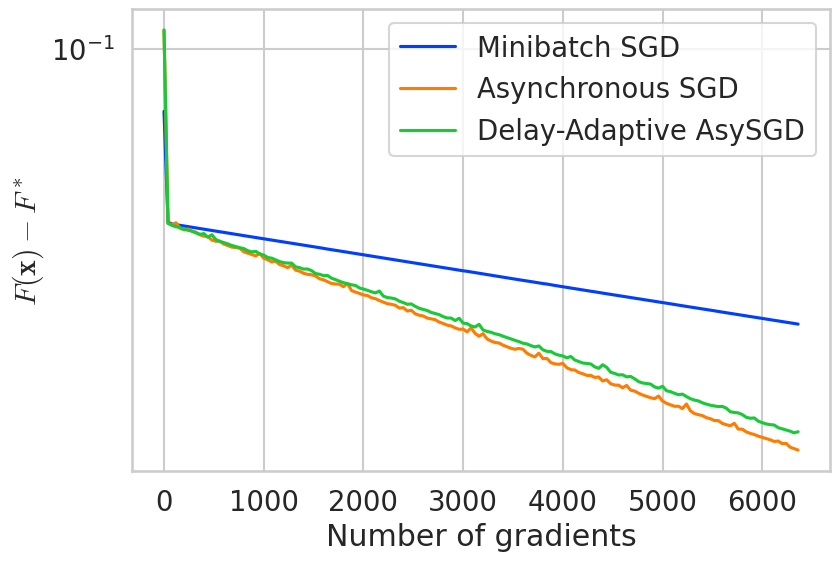

In [45]:
plt.plot(its_ * num_workers, losses_ - f_min, label='Minibatch SGD')
plt.plot(its_as, losses_as - f_min, label='Asynchronous SGD')
plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


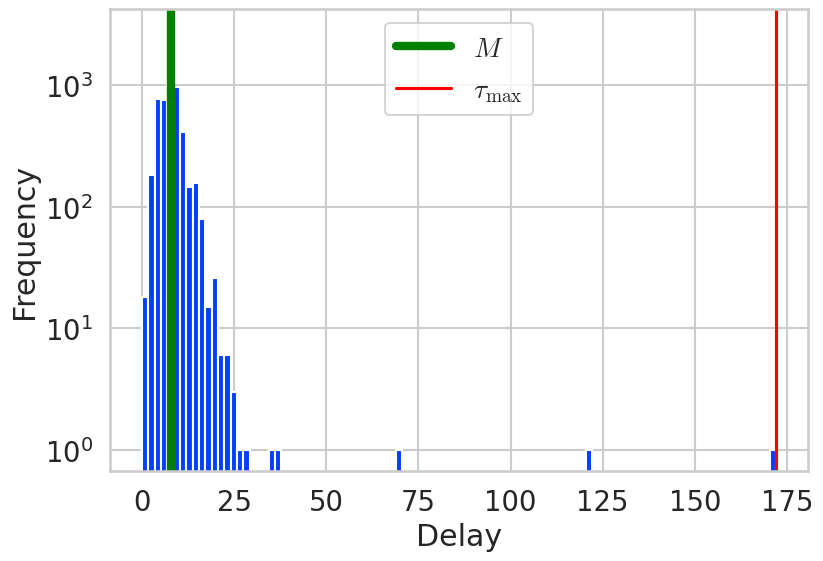

In [14]:
plt.hist(delays, bins=100)
plt.axvline(num_workers, color='green', label=r'$M$', linewidth=6)
plt.axvline(np.max(delays), color='red', label=r'$\tau_{\max}$')
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')